# C3DIS simulation autoencoder

Generate good reconstructions.

In [2]:
import numpy, matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import torch, torch.nn as nn, torch.optim as optim
import scipy.ndimage
from cmocean import cm
from sklearn.decomposition import PCA

In [8]:
torch.cuda.get_device_name(torch.cuda.current_device())

'GeForce GTX 1080'

## Generate data

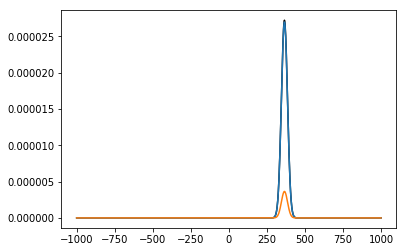

In [9]:
phi_samp, rmsf = numpy.loadtxt('dae/rmsf.txt', dtype=complex).T
rmsf = rmsf[500:-500]
N = 10000
phi_channels = 1000
phis = numpy.linspace(-1000, 1000, phi_channels)
sigma = 2e-5

numpy.random.seed(0)

def generate_spectra(N=N // 2, complexity=2):
    depths = numpy.random.uniform(-800, 800, size=(N, complexity))
    depth_indices = numpy.searchsorted(phis, depths)
    phases = numpy.random.uniform(-numpy.pi, numpy.pi, size=(N, complexity))
    amps = numpy.random.uniform(0.0005, 0.0020, size=(N, complexity))
    spectra = numpy.zeros(shape=(N, len(phis)), dtype='complex')
    for i in range(N):
        spectra[i, depth_indices[i]] += (amps[i] * (
            numpy.cos(phases[i]) + 1j * numpy.sin(phases[i])))
    return spectra

simple_spectra = generate_spectra(complexity=1)
complex_spectra = generate_spectra(complexity=2)
spectra = numpy.concatenate([simple_spectra, complex_spectra], axis=0)
labels = numpy.zeros(N, dtype=bool)
labels[:N//2] = False
labels[N//2:] = True

indices = numpy.arange(N)
numpy.random.shuffle(indices)

spectra = spectra[indices]
labels = labels[indices]

targets = scipy.ndimage.gaussian_filter1d(spectra.real, 10) + scipy.ndimage.gaussian_filter1d(spectra.imag, 10) * 1j

%matplotlib inline
plt.plot(phis, abs(targets[0]), c='black')
plt.plot(phis, targets[0].real)
plt.plot(phis, targets[0].imag)

In [13]:
# Normalise.
spectrum_max = abs(spectra).max()
print('Spectrum max', spectrum_max)
spectra /= spectrum_max

target_max = abs(targets).max()
print('Target max', target_max)
targets /= target_max

Spectrum max 1.0
Target max 1.0


In [ ]:
# PCA on the convolved spectra.
convolved_spectra_real = scipy.ndimage.convolve1d(spectra.real, rmsf.real)

In [ ]:
pca_real = PCA(n_components=64).fit(convolved_spectra_real)

## Deconvolving autoencoder

In [ ]:
class DeconvolvingAutoencoder(nn.Module):
    loss_fn = nn.MSELoss()

    def __init__(self, rmsf, pca):
        super().__init__()
        self.real_rmsf = torch.from_numpy(rmsf.real.reshape(1, 1, -1)).float()
        self.imag_rmsf = torch.from_numpy(rmsf.imag.reshape(1, 1, -1)).float()
        self.pca = pca
        
        self.pca_weight = numpy.transpose(
            numpy.tile(pca.components_, (16, 1, 1)), (1, 0, 2)).reshape((pca.n_components, 16000))

        # N x 1000 x 2
        self.encode = nn.Sequential(
            nn.Conv1d(2, 8, 5, padding=2),
            nn.Tanh(),
            nn.Conv1d(8, 16, 5, padding=2),
            nn.Tanh(),
        )
        
        self.linear_encode = nn.Linear(16 * 1000, pca.n_components)
        self.linear_encode.weight.data = torch.from_numpy(self.pca_weight)
        self.linear_decode = nn.Linear(pca.n_components, 16 * 1000)
        self.linear_decode.weight.data = torch.from_numpy(self.pca_weight.T)

        self.decode = nn.Sequential(
            nn.ConvTranspose1d(16, 8, 5, padding=2),
            nn.Tanh(),
            nn.ConvTranspose1d(8, 2, 5, padding=2),
            nn.Tanh(),
        )
        self.deconv = nn.Sequential(
            nn.Conv1d(2, 64, 3, padding=1),
            nn.Tanh(),
            nn.Conv1d(64, 128, 3, padding=1),
            nn.Tanh(),
            nn.ConvTranspose1d(128, 2, 3, padding=1),
        )
    
    def conv_RMSF(self, x):
        x_real = x[:, 0, :].view((x.shape[0], 1, x.shape[2]))
        x_imag = x[:, 1, :].view((x.shape[0], 1, x.shape[2]))
        conv_real = nn.functional.conv1d(x_real, self.real_rmsf, padding=500)
        conv_imag = nn.functional.conv1d(x_imag, self.imag_rmsf, padding=500)
        return torch.cat([conv_real, conv_imag], dim=1)[:, :, :-1]

    def forward(self, x):
        conv = self.conv_RMSF(x)
        encoded = self.linear_encode(self.encode(conv).view(-1, 16 * 1000))
        recon = self.decode(self.linear_decode(encoded).view(-1, 16, 1000))
        deconv = self.deconv(recon)
        deconv[:, :, :3] = 0
        deconv[:, :, -3:] = 0
        return conv, recon, deconv
    
    @classmethod
    def loss(cls, init, conv, conv_recon, init_recon, alpha=0.5):
        loss_conv = cls.loss_fn(conv_recon, conv)
        loss_e2e = cls.loss_fn(init_recon, init)
            
        return loss_conv * alpha + (1 - alpha) * loss_e2e

In [175]:
dcae = DeconvolvingAutoencoder(rmsf, pca_real).float()
# state_dict = torch.load('dcae500.dat', map_location='cpu')
# dcae.load_state_dict(state_dict)
# dcae.eval()
optimiser = optim.Adam(dcae.parameters(), lr=1e-4)
losses = []

In [176]:
torch_X = torch.from_numpy(numpy.stack([spectra.real, spectra.imag], axis=1)).float()[:1]
torch_targets = torch.from_numpy(numpy.stack([targets.real, targets.imag], axis=1)).float()[:1]
torch_X.shape

torch.Size([1, 2, 1000])

<IPython.core.display.Javascript object>


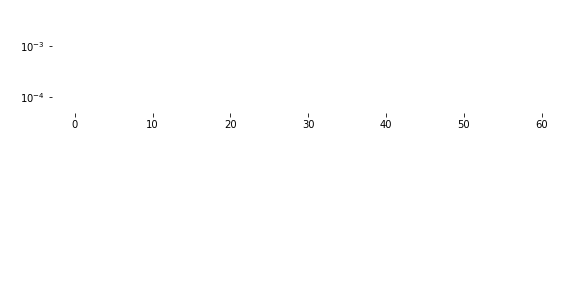

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


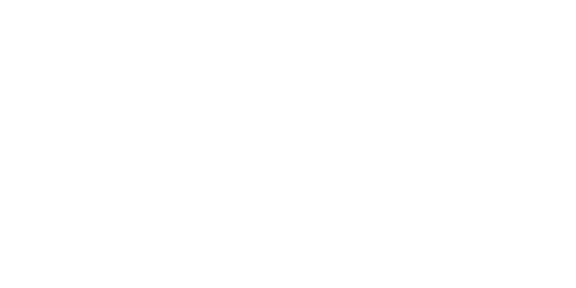

In [177]:
%matplotlib notebook
n_epochs = 1000
batch_size = 100
bar = tqdm(total=n_epochs * len(torch_X))

fig = plt.figure(figsize=(8, 4))
ax_losses = plt.subplot2grid((2, 4), (0, 0), colspan=4)
plt_losses, = ax_losses.plot(range(len(losses)), losses)
ax_losses.set_yscale('log')
ax_init = plt.subplot2grid((2, 4), (1, 0))
ax_init.set_xlabel('$\\phi$')
ax_init.set_ylabel('$F(\\phi)$')
plt_init, = ax_init.plot(phis, abs(spectra[0]), c='blue')
ax_conv = plt.subplot2grid((2, 4), (1, 1))
ax_conv.set_xlabel('$\\phi$')
ax_conv.set_ylabel('$F(\\phi)$')
plt_conv, = ax_conv.plot(phis, abs(spectra[0]), c='green')
ax_recon = plt.subplot2grid((2, 4), (1, 2))
ax_recon.set_xlabel('$\\phi$')
ax_recon.set_ylabel('$F(\\phi)$')
plt_recon, = ax_recon.plot(phis, abs(spectra[0]), c='green')
ax_deconv = plt.subplot2grid((2, 4), (1, 3))
ax_deconv.set_xlabel('$\\phi$')
ax_deconv.set_ylabel('$F(\\phi)$')
plt_deconv, = ax_deconv.plot(phis, abs(spectra[0]), c='blue')

plt.tight_layout()

def power(spec):
    return numpy.sqrt(spec[0].detach().numpy() ** 2 + spec[1].detach().numpy() ** 2)

for e in (range(n_epochs)):
    subset_idx = torch.randperm(len(torch_X))
    torch_X_ = torch_X[subset_idx]
    torch_targets_ = torch_targets[subset_idx]
    for subset_i in (range(0, len(torch_X_), batch_size)):
        optimiser.zero_grad()
        subset = torch_X_[subset_i:subset_i + batch_size]
        subset_targets = torch_targets_[subset_i:subset_i + batch_size]
        recons = dcae.forward(subset)
        loss = dcae.loss(subset_targets, *recons, alpha=0.1)
        loss.backward()
        optimiser.step()
        losses.append(loss.item())
        bar.postfix = '{:0.4e}'.format(loss.item())
        bar.update(len(subset))
        
        recon = dcae.forward(torch_X[:1])
        
        plt_losses.set_data(range(len(losses)), losses)
        ax_losses.relim()
        ax_losses.autoscale_view()
        
        plt_init.set_ydata(power(torch_X[0]))
        ax_init.relim()
        ax_init.autoscale_view()
        
        plt_conv.set_ydata(power(recon[0][0]))
        ax_conv.relim()
        ax_conv.autoscale_view()
        
        plt_recon.set_ydata(power(recon[1][0]))
        ax_recon.set_ylim(ax_conv.get_ylim())
        ax_recon.autoscale_view()
        
        plt_deconv.set_ydata(power(recon[2][0]))
        ax_deconv.set_ylim(ax_init.get_ylim())
        ax_deconv.autoscale_view()

        fig.canvas.draw()

## Pictures for talk

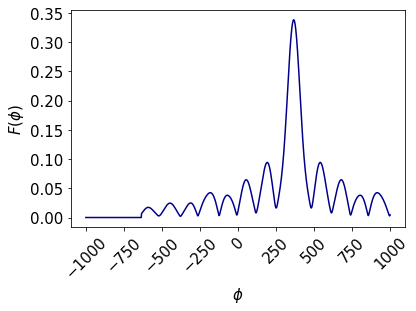

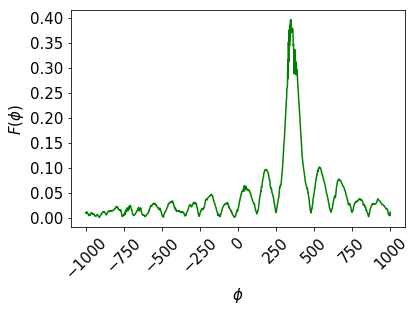

(-0.5, 7.5, 7.5, -0.5)

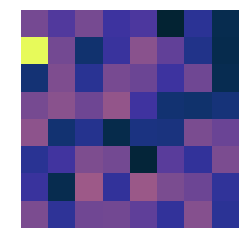

In [34]:
# autoencoder
%matplotlib inline
plt.figure()
fs = 15
recons = dcae.forward(torch_X[:1])
encoding = dcae.linear_encode(dcae.encode(torch_X[:1]).view(-1, 16 * 1000))

plt.plot(phis, power(recons[0][0]), c='darkblue')
plt.xlabel('$\\phi$', fontsize=fs)
plt.xticks(fontsize=fs, rotation=45)
plt.ylabel('$F(\\phi)$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.show()

plt.plot(phis, power(recons[1][0]), c='green')
plt.xlabel('$\\phi$', fontsize=fs)
plt.xticks(fontsize=fs, rotation=45)
plt.ylabel('$F(\\phi)$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.show()

encoding = encoding.detach().numpy().ravel()
plt.imshow(encoding.reshape((8, 8)), cmap=cm.thermal)
plt.axis('off')

(64,)


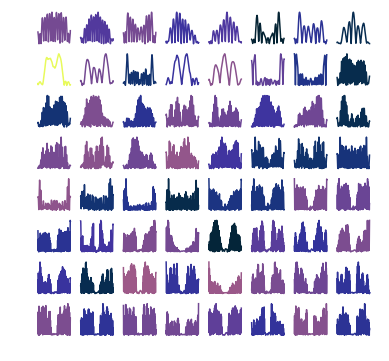

In [36]:
colours = cm.thermal((encoding - encoding.min()) / (encoding.max() - encoding.min()))
print(encoding.shape)
plt.figure(figsize=(6, 6))
weight = dcae.linear_encode.weight.data.detach().numpy().reshape(64, 16, 1000)
for i, (colour, component) in enumerate(zip(colours, weight)):
    plt.subplot(8, 8, i + 1)
    plt.plot(phis, numpy.sqrt(component[0] ** 2 + component[1] ** 2), c=colour)
    plt.axis('off')

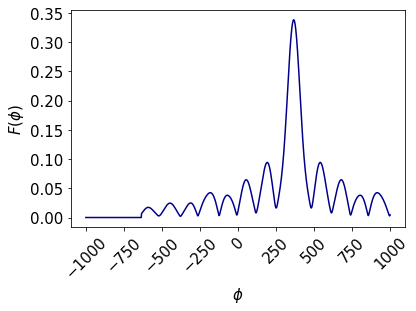

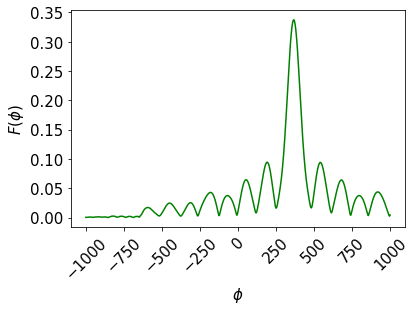

(-0.5, 7.5, 7.5, -0.5)

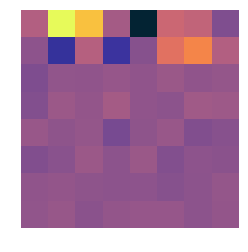

In [166]:
# PCA


%matplotlib inline
plt.figure()
fs = 15
pca = PCA(n_components=64)
recons = dcae.forward(torch_X[:1000])
encoding = pca.fit_transform(recons[0].detach().numpy().reshape(1000, 2 * 1000))[0]
recon = pca.inverse_transform(encoding).reshape(2, 1000)
recon = recon[0] + recon[1] * 1j

plt.plot(phis, power(recons[0][0]), c='darkblue')
plt.xlabel('$\\phi$', fontsize=fs)
plt.xticks(fontsize=fs, rotation=45)
plt.ylabel('$F(\\phi)$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.show()

plt.plot(phis, abs(recon), c='green')
plt.xlabel('$\\phi$', fontsize=fs)
plt.xticks(fontsize=fs, rotation=45)
plt.ylabel('$F(\\phi)$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.show()

plt.imshow(encoding.reshape((8, 8)), cmap=cm.thermal)
plt.axis('off')

In [167]:
pca_encoding = pca.transform(recons[0].detach().numpy().reshape(1000, 2 * 1000))

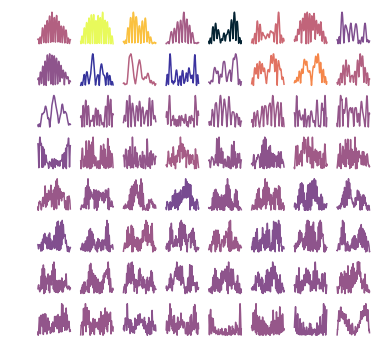

In [31]:
colours = cm.thermal((encoding - encoding.min()) / (encoding.max() - encoding.min()))
plt.figure(figsize=(6, 6))
for i, (colour, component) in enumerate(zip(colours, pca.components_)):
    plt.subplot(8, 8, i + 1)
    plt.plot(phis, numpy.sqrt(component[:1000] ** 2 + component[1000:] ** 2), c=colour)
    plt.axis('off')

## Trial on real data

In [101]:
jack = numpy.load('/home/alger/repos/brushtail/dae/fdf_1.npy')

In [102]:
jack = numpy.stack([jack.real, jack.imag]).reshape((1, 2, 1000)) / spectrum_max

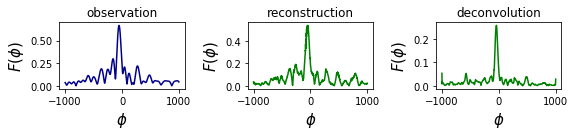

In [103]:
# autoencoder
%matplotlib inline
fig, (a, b, c) = plt.subplots(1, 3, figsize=(8, 2))
fs = 15
encoding = dcae.linear_encode(dcae.encode(torch.from_numpy(jack).float()).view(-1, 16 * 1000))
reconstruction = dcae.decode(dcae.linear_decode(encoding).view(-1, 16, 1000))
deconv = dcae.deconv(reconstruction)

a.plot(phis, power(torch.from_numpy(jack)[0]), c='darkblue')
a.set_xlabel('$\\phi$', fontsize=fs)
a.set_ylabel('$F(\\phi)$', fontsize=fs)
a.set_title('observation')

b.plot(phis, power(reconstruction[0]), c='green')
b.set_xlabel('$\\phi$', fontsize=fs)
b.set_ylabel('$F(\\phi)$', fontsize=fs)
b.set_title('reconstruction')

c.plot(phis, power(deconv[0]), c='green')
c.set_xlabel('$\\phi$', fontsize=fs)
c.set_ylabel('$F(\\phi)$', fontsize=fs)
c.set_title('deconvolution')

# plt.imshow(deconv.detach().numpy().reshape((8, 8)), cmap=cm.thermal)
# plt.axis('off')

plt.tight_layout()